# Model Training: Wingers - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Winger position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import  KFold
import shap
shap.initjs()

In [29]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [30]:
wingers = data[data['POSITION'].isin(['r', 'l', 'l, r'])].copy()

# Select only players with 41 or more games played
wingers_41GP = wingers[(wingers['GP'] >= 41)].copy()
test_train_data = wingers_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP', 'CF/GP'])

In [31]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]

# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

In [32]:
# Assuming 'test_train_data' and 'numerical_features' are defined as in your script
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000, max_depth=5, reg_lambda=2, eta=0.01)

# Define the pipeline as before
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross-validation for automated feature selection
# Set min_features_to_select to 1 to ensure at least one feature is selected
# cv=n for n-fold cross-validation
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(5), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')

Mean Squared Error: 0.0004698111907001641
Optimal number of features : 44


In [33]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

# 
# Training performance score: -0.49653435225835474
# Testing performance score: -0.5185301548734333

Training performance score: -0.6875654549721304
Testing performance score: -0.6219476766543071


/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [34]:
# Save the model to a file
import joblib

model_dir = 'Winger_Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

joblib.dump(pipeline, f'{model_dir}/winger_salary_pipeline.pkl')
joblib.dump(numerical_features, f'{model_dir}/winger_salary_features.pkl')

['Winger_Model/winger_salary_features.pkl']

In [35]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [36]:
# Create a feature column in Centers for the predicted salary
wingers['PRED_SALARY_PERCENTAGE'] = pipeline.predict(wingers)

# Create a column for the actual predicted salary
wingers['PRED_AAV'] = wingers['PRED_SALARY_PERCENTAGE'] * wingers['SALARY CAP']
wingers['PRED_AAV'] = wingers['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
wingers['DIFF'] = wingers['PRED_AAV'] - wingers['AAV']

# Convert to dollars
wingers['PRED_AAV'] = convert_to_dollars(wingers, 'PRED_AAV')
wingers['AAV'] = convert_to_dollars(wingers, 'AAV')
wingers['DIFF'] = convert_to_dollars(wingers, 'DIFF')

In [37]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = wingers.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
424,alex ovechkin,2008-09,"$9,538,462.00","$8,745,270.00","$-793,192.00",0.154238
2812,alex ovechkin,2012-13,"$9,538,462.00","$9,153,237.00","$-385,225.00",0.152554
1532,alex ovechkin,2010-11,"$9,538,462.00","$8,993,494.00","$-544,968.00",0.151406
3527,alex ovechkin,2013-14,"$9,538,462.00","$8,815,482.00","$-722,980.00",0.137099
4303,alex ovechkin,2014-15,"$9,538,462.00","$9,437,582.00","$-100,880.00",0.136777
11468,artemi panarin,2023-24,"$11,642,857.00","$11,253,459.00","$-389,398.00",0.134772
11588,david pastrnak,2023-24,"$11,250,000.00","$11,119,465.00","$-130,535.00",0.133167
5104,alex ovechkin,2015-16,"$9,538,462.00","$9,367,391.00","$-171,071.00",0.131196
8038,patrick kane,2018-19,"$10,500,000.00","$10,353,907.00","$-146,093.00",0.130238
6474,patrick kane,2016-17,"$10,500,000.00","$9,503,812.00","$-996,188.00",0.130189


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for wingers')

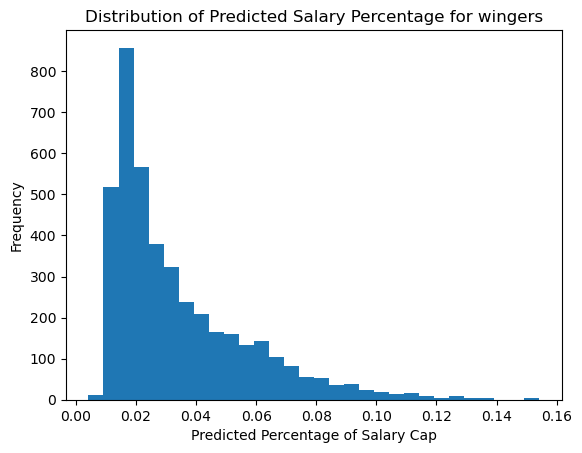

In [38]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(wingers['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Percentage of Salary Cap')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for wingers')

Text(0.5, 1.0, 'Distribution of Actual Salary Cap Percentage for wingers')

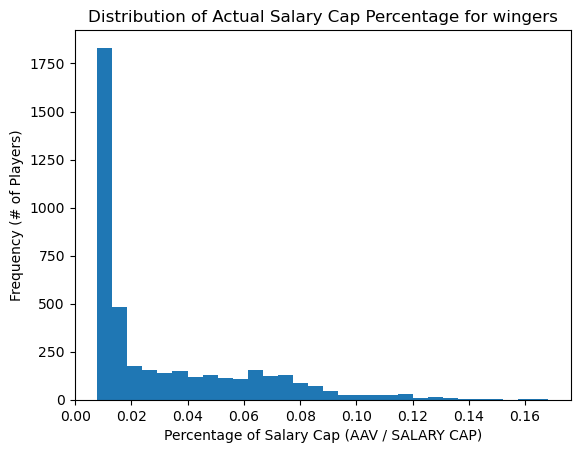

In [39]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(wingers['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Percentage of Salary Cap (AAV / SALARY CAP)')
plt.ylabel('Frequency (# of Players)')
plt.title('Distribution of Actual Salary Cap Percentage for wingers')

In [40]:
# Filter players with over 41 GP
filtered_data = wingers[(wingers['GP'] > 60) & (wingers['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11701,bos,james van riemsdyk,2023-24,"$1,000,000.00","$5,135,507.00","$4,135,507.00",0.061503,4135507.0
11754,col,jonathan drouin,2023-24,"$825,000.00","$4,947,891.00","$4,122,891.00",0.059256,4122891.0
11694,stl,jake neighbours,2023-24,"$863,333.00","$3,877,021.00","$3,013,688.00",0.046431,3013688.0
11635,s.j,fabian zetterlund,2023-24,"$1,450,000.00","$4,395,718.00","$2,945,718.00",0.052643,2945718.0
11639,s.j,filip zadina,2023-24,"$1,100,000.00","$3,823,125.00","$2,723,125.00",0.045786,2723125.0
11429,l.a,alex laferriere,2023-24,"$875,000.00","$3,230,909.00","$2,355,909.00",0.038694,2355909.0
11495,t.b,brandon hagel,2023-24,"$1,500,000.00","$3,723,488.00","$2,223,488.00",0.044593,2223488.0
12143,edm,zach hyman,2023-24,"$5,500,000.00","$7,550,048.00","$2,050,048.00",0.090420,2050048.0
11776,cbj,justin danforth,2023-24,"$975,000.00","$2,619,319.00","$1,644,319.00",0.031369,1644319.0
11603,ott,dominik kubalik,2023-24,"$2,500,000.00","$4,100,443.00","$1,600,443.00",0.049107,1600443.0


In [41]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11497,stl,brandon saad,2023-24,"$4,500,000.00","$4,188,521.00","$-311,479.00",0.050162,-311479.0
11689,bos,jake debrusk,2023-24,"$4,000,000.00","$3,682,674.00","$-317,326.00",0.044104,-317326.0
11787,stl,kasperi kapanen,2023-24,"$3,200,000.00","$2,842,984.00","$-357,016.00",0.034048,-357016.0
11855,dal,mason marchment,2023-24,"$4,500,000.00","$4,138,004.00","$-361,996.00",0.049557,-361996.0
11427,wpg,alex iafallo,2023-24,"$4,000,000.00","$3,635,583.00","$-364,417.00",0.043540,-364417.0
12096,tor,tyler bertuzzi,2023-24,"$5,500,000.00","$5,123,797.00","$-376,203.00",0.061363,-376203.0
11468,nyr,artemi panarin,2023-24,"$11,642,857.00","$11,253,459.00","$-389,398.00",0.134772,-389398.0
11668,det,j.t. compher,2023-24,"$5,100,000.00","$4,639,238.00","$-460,762.00",0.055560,-460762.0
11940,wpg,nikolaj ehlers,2023-24,"$6,000,000.00","$5,473,731.00","$-526,269.00",0.065554,-526269.0
11735,phi,joel farabee,2023-24,"$5,000,000.00","$4,435,828.00","$-564,172.00",0.053124,-564172.0


In [42]:
predictions = wingers[['PLAYER', 'SEASON', 'PRED_AAV','PRED_SALARY_PERCENTAGE']]

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'wingers_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)